In [253]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json
import re
import copy
import json
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.patches as mpatches
import re

from sklearn import metrics as sklearn_metrics

In [254]:
sns.set(context="paper", style="white",
        font_scale=2, palette="Blues_r",
        rc={"figure.figsize": (20,10), "legend.fontsize": 20,
                         "legend.title_fontsize" : 20, 
            "xtick.major.size": 8, "ytick.major.size": 8,
            "axes.spines.top" : False, 
            "axes.spines.right" : False,
           "lines.linewidth" : 3, 
           "font.family" : "sans-serif", 
            "font.sans-serif" : "Arial"
           
           })

## Helpers

In [255]:
def get_colors(x : list):
    """ Get colors for x, a list of lists, where each sublist gets its own hue"""
    num_cats = len(x)
    
    color_list = sns.color_palette("Paired", n_colors=num_cats * 2)
    colors = []
    for index, i in enumerate(x): 
        
        num_new_cols = len(i)

        start_col = color_list[index*2]
        end_col = color_list[index*2+1]
        start, end = np.array(start_col), np.array(end_col)
        new_cols = np.linspace(start, end, num_new_cols).tolist()
        colors.extend(new_cols)
    return colors

## CV Plots

In [269]:

def parse_log(model, fname):
    data = []

    if 'hybrid' in model or 'gp' in model:
        uncertainty = 'GP-based uncertainty'
    elif model == 'mlper5g' or model == 'bayesnn':
        uncertainty = 'Other uncertainty'
    else:
        uncertainty = 'No uncertainty'

    with open(fname) as f:
        for line in f:

            starts_with_year = re.search(r"^20[0-9][0-9]-", line)
            if starts_with_year is None:
                continue
            if ' | ' not in line or ' for ' not in line:
                continue

            log_body = line.split(' | ')[1]

            [ metric, log_body ] = log_body.split(' for ')

            [ quadrant, log_body ] = log_body.split(': ')

            if metric == 'MAE':
                continue
            elif metric == 'MSE':
                value = float(log_body)
            elif metric == 'Pearson rho':
                value = float(log_body.strip('()').split(',')[0])
            elif metric == 'Spearman r':
                value = float(log_body.split('=')[1].split(',')[0])
            else:
                continue

            data.append([ model, metric, quadrant, value, uncertainty ])

    return data

In [270]:
# Define constants
models = [
    'mlper1',
    'hybrid',
    'ridgesplit',
    'ridgesplit_morgan',
    'hybridsplit',
    'mlper1split',
]


method_name_map = {
    "mlper1": "MLP",
    "hybrid" : "GP + MLP",
    "ridgesplit" : "Ridge Regr. (JT-VAE)",
    "ridgesplit_morgan" : "Ridge Regr. (Morgan)",
    "hybridsplit" : "GP + MLP (Single)",
    "mlper1split" : "MLP (Single)",
}

panel_height = 3.5
panel_width = 6

orig_models = ["hybrid", "mlper1"]
no_cpi = ["hybridsplit", "mlper1split"]
ours = ["ridgesplit", "ridgesplit_morgan"]

uq_methods = ["hybrid", "hybridsplit"]


joint_list = [orig_models, no_cpi, ours]
full_list = [x for i in joint_list for x in i]
gap_size = 0.2
shift_factors = np.array([index *gap_size  for index, i in enumerate(joint_list) for j in i])
plot_positions = np.arange(len(full_list)) + shift_factors
x_labels = ["Theirs (CPI)"] * len(orig_models) + ["Theirs (No CPI)"] * len(no_cpi) \
                                             + ["Ours (No CPI)"] * len(ours) 
x_colors = get_colors(joint_list)
color_map = dict(zip(full_list, x_colors)) # dict of colors
out_dir = "../results/figures/cv"
os.makedirs(out_dir, exist_ok=True)

In [271]:
# Get data frame
data = []
for model in models:
    for seed in range(5):
        fname = f'../target/log/train_davis2011kinase_{model}_{seed}.log'
        if os.path.exists(fname): 
            data += parse_log(model, fname)
        else:
            print(fname)

df = pd.DataFrame(data, columns=[
    'model', 'metric', 'quadrant', 'value', 'uncertainty',
])

metric_map = {"Pearson rho" : r"Pearson $\rho$",
              "Spearman r" : r"Spearman $\rho$",             
             }


In [272]:
# Unknown repurpose: Repurpose novel chemicals... 

../results/figures/cv/benchmark_cv_MSE_unknown_all.pdf


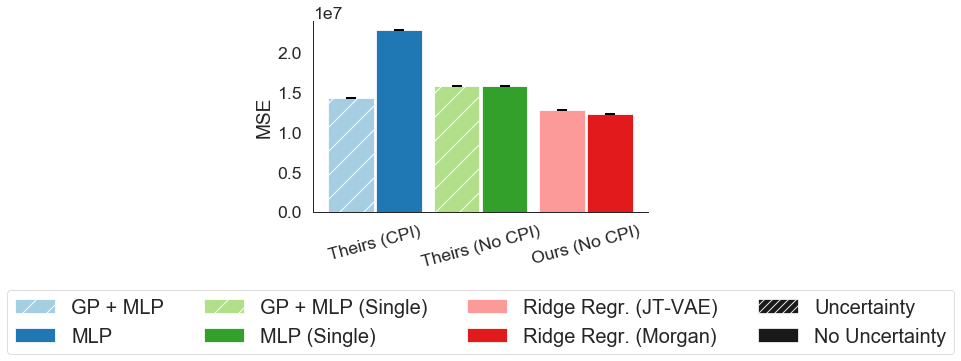

../results/figures/cv/benchmark_cv_Pearson rho_unknown_all.pdf


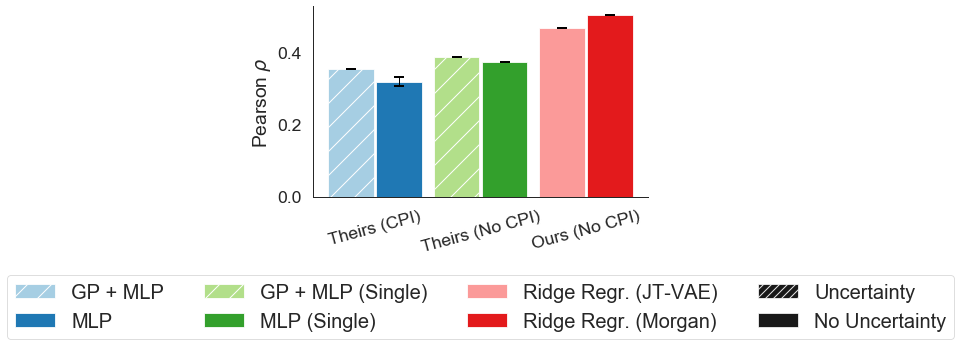

../results/figures/cv/benchmark_cv_Spearman r_unknown_all.pdf


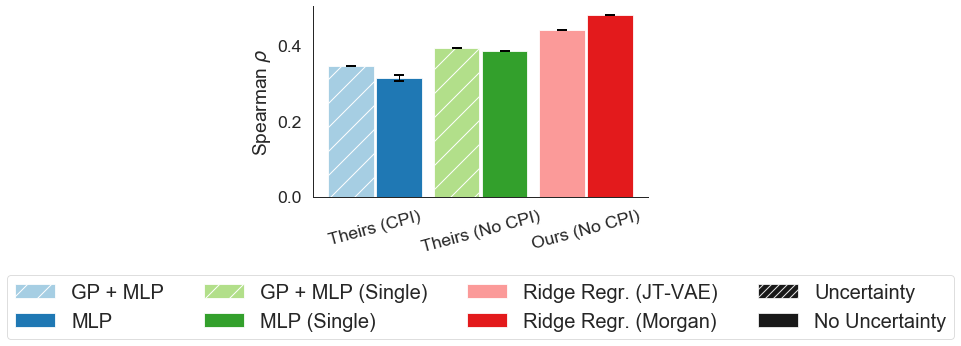

../results/figures/cv/benchmark_cv_MSE_unknown_novel.pdf


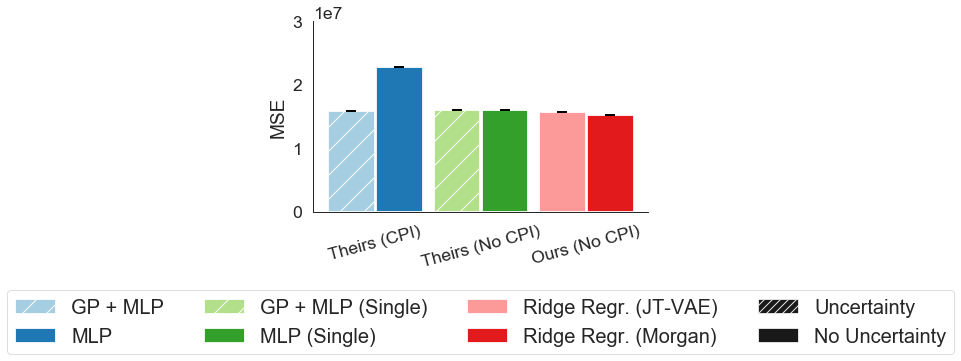

../results/figures/cv/benchmark_cv_Pearson rho_unknown_novel.pdf


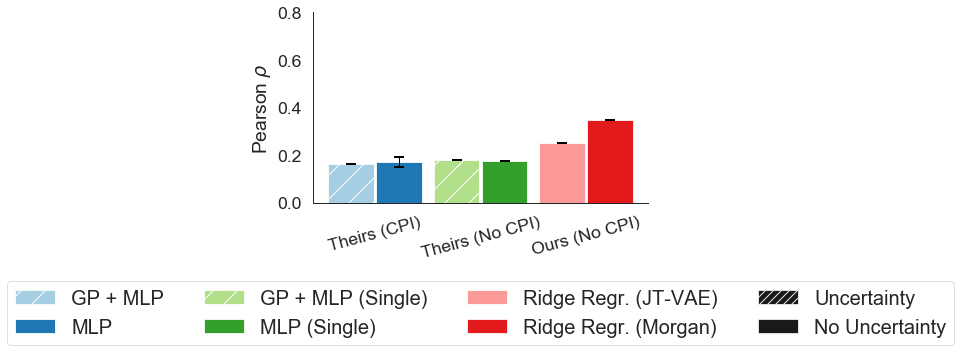

../results/figures/cv/benchmark_cv_Spearman r_unknown_novel.pdf


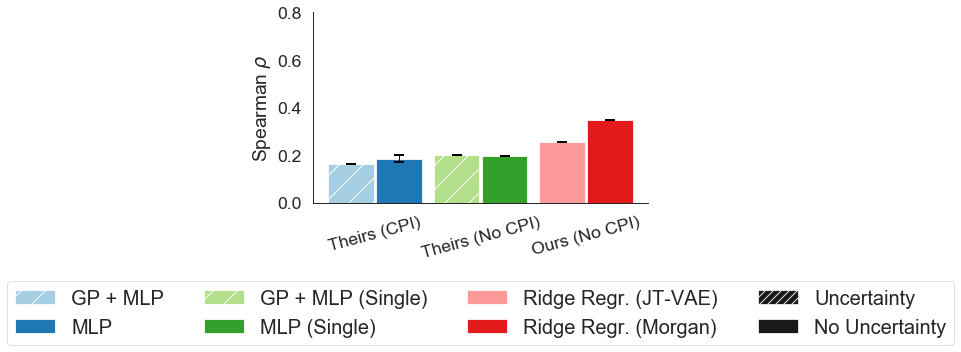

../results/figures/cv/benchmark_cv_MSE_unknown_repurpose.pdf


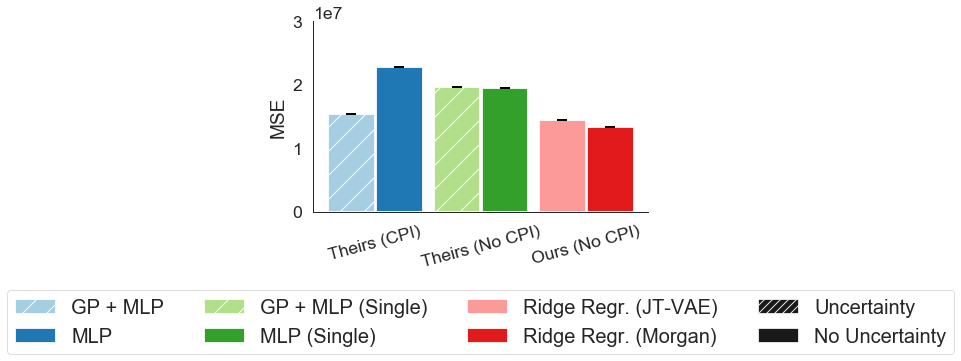

../results/figures/cv/benchmark_cv_Pearson rho_unknown_repurpose.pdf


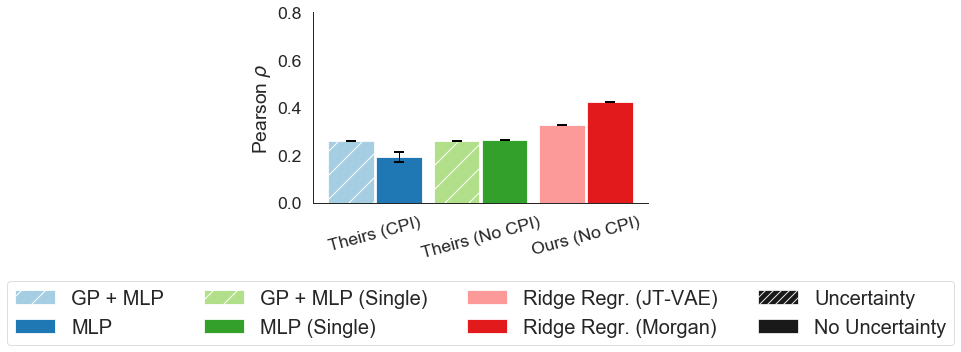

../results/figures/cv/benchmark_cv_Spearman r_unknown_repurpose.pdf


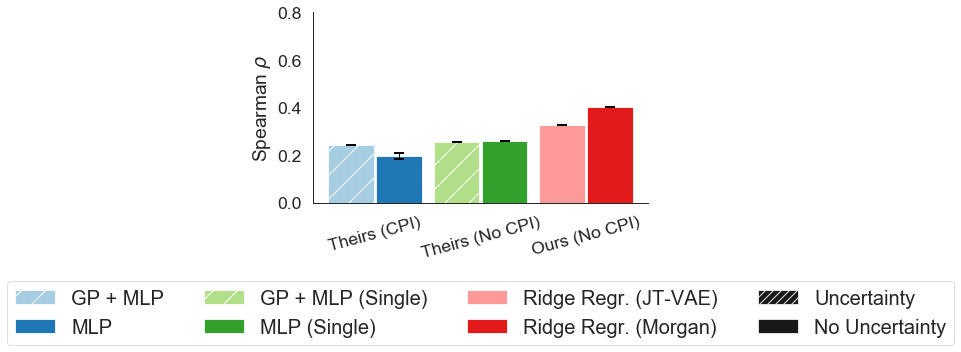

../results/figures/cv/benchmark_cv_MSE_unknown_side.pdf


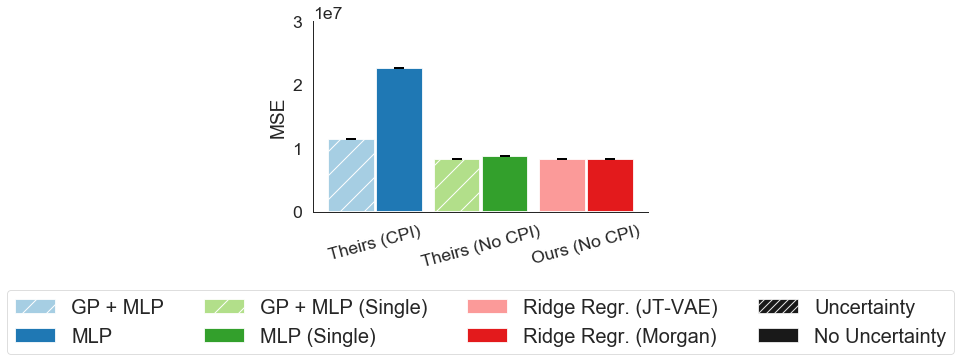

../results/figures/cv/benchmark_cv_Pearson rho_unknown_side.pdf


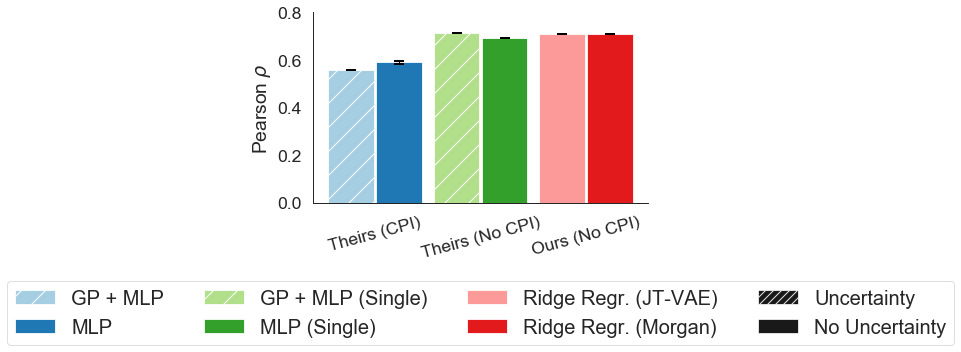

../results/figures/cv/benchmark_cv_Spearman r_unknown_side.pdf


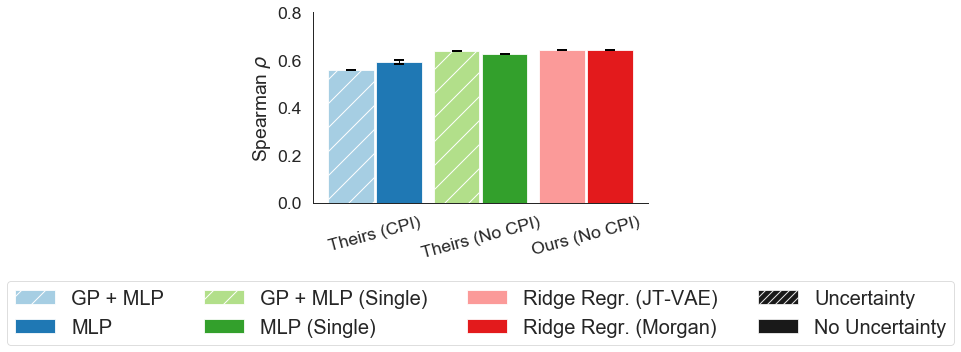

In [273]:

for quadrant in quadrants[1:]:
    quadrant_df = df[df['quadrant'] == quadrant]

    for metric in metrics:
        
        metric_df = quadrant_df[quadrant_df['metric'] == metric]
        plt.figure(figsize=(panel_width, panel_height))
        bars = []
        for color, plot_position, method in zip(x_colors, plot_positions, full_list):
            temp_df = metric_df[metric_df["model"] == method]
            vals = temp_df["value"]
            bar_height = np.mean(vals)
            error_height = 1.96 * stats.sem(vals)
            label_name = method_name_map[method]
            hatch = "/" if method in uq_methods else None
            bars.append(plt.bar(plot_position, bar_height, color=color, label = label_name, width=0.95,
                               hatch = hatch))
            plt.errorbar(plot_position, bar_height, yerr= error_height, 
                         color="Black", capsize=5, capthick=2, linewidth=1)

        # Set labels
        ticks, labels = [], []
        for label in np.unique(x_labels): 
            avg_pos = np.mean(np.array(plot_positions)[np.array(x_labels) == label])
            ticks.append(avg_pos)
            labels.append(label)
#         for tick, label in zip(ticks, labels): 
#             plt.text(tick, -0.4, label, rotation=30,
#                     ha="center", va="center")#label, (tick, -0.2), )

        if (metric == 'Pearson rho' or metric == 'Spearman r') \
           and quadrant != 'unknown_all':
            plt.ylim([ 0.0, 0.8 ])
        if metric == 'MSE' and quadrant != 'unknown_all':
            plt.ylim([ -0.01e7, 3e7 ])
        plt.xticks(ticks, labels=labels, rotation=15)
        plt.ylabel(metric_map.get(metric, metric))
        
        handles = []
        handles.append(mpatches.Patch(facecolor="black", alpha=0.9,hatch="///",label="Uncertainty"))
        handles.append(mpatches.Patch(facecolor="black", alpha=0.9,hatch="",label="No Uncertainty"))
        bars.extend(handles)
        plt.legend(handles=bars, ncol=int(len(full_list) / 2 + 1), 
               bbox_to_anchor = (0.5, -0.8),loc="lower center", )        

        save_name = os.path.join(out_dir, f'benchmark_cv_{metric}_{quadrant}.pdf')
        plt.savefig(save_name, bbox_inches="tight")
        print(save_name)
        plt.show()
        plt.close()

## Exploit Plots

In [278]:
def parse_log(model, fname):
    data = []
    reseed = -1
    lead_num = 0

    if model == 'gp' or 'hybrid' in model:
        uncertainty = 'GP-based uncertainty'
    elif model == 'mlper5g' or model == 'bayesnn':
        uncertainty = 'Other uncertainty'
    else:
        uncertainty = 'No uncertainty'

    with open(fname) as f:

        while True:
            line = f.readline()
            if not line:
                break

            starts_with_year = re.search(r"^20[0-9][0-9]-", line)
            if starts_with_year is None:
                continue
            if not ' | ' in line:
                continue

            line = line.split(' | ')[1]

            if line.startswith('Iteration'):
                lead_num = 0
                reseed += 1
                continue

            elif line.startswith('\tAcquire '):
                fields = line.strip().split()

                Kd = 10000 - float(fields[-1])
                chem_idx = int(fields[1].lstrip('(').rstrip(','))
                prot_idx = int(fields[2].strip().rstrip(')'))
                chem_name = fields[3]
                prot_name = fields[4]

                data.append([
                    model, Kd, lead_num, reseed, uncertainty,
                    chem_name, prot_name, chem_idx, prot_idx
                ])

                lead_num += 1
                continue

    return data

In [279]:
out_dir = "../results/figures/exploit"
os.makedirs(out_dir, exist_ok=True)

In [288]:
models = [
    'hybrid',
    'mlper1',
    'ridgesplit'
]

model_renames = {"hybrid" : "GP+MLP\nTheirs (CPI)",
                 "mlper1" : "MLP\nTheirs (CPI)",
                 "ridgesplit" : "Ridge Regr.\nOurs (No CPI)"}


panel_height = 3.5
panel_width = 4

plot_positions = np.arange(len(models))
ticks = plot_positions
tick_labels = [model_renames[model] for model in models]

In [292]:
data = []
for model in models:
    for seed in range(5):
        fname = f'../iterate/log/iterate_davis2011kinase_{model}_{seed}.log'
        if os.path.exists(fname): 
            data += parse_log(model, fname)

df = pd.DataFrame(data, columns=[
    'model', 'Kd', 'lead_num', 'seed', 'uncertainty',
    'chem_name', 'prot_name', 'chem_idx', 'prot_idx',
])

df['LogKd'] = np.log10(df['Kd'])
df['Kdmicro'] = (df['Kd']) / 1000 # convert fromm nM to micromolar

x_label_map = {"LogKd": "$Log(K_d)$",
               "Kd" : "$K_d$",
              "Kdmicro" : "True $K_d$ ($\mu M$)"}
val_name = "Kdmicro"

In [293]:
df

model       Kd  lead_num  seed           uncertainty  \
0         hybrid     19.0         0     0  GP-based uncertainty   
1         hybrid     47.0         1     0  GP-based uncertainty   
2         hybrid    720.0         2     0  GP-based uncertainty   
3         hybrid    910.0         3     0  GP-based uncertainty   
4         hybrid    600.0         4     0  GP-based uncertainty   
...          ...      ...       ...   ...                   ...   
1495  ridgesplit  10000.0        95     0        No uncertainty   
1496  ridgesplit    130.0        96     0        No uncertainty   
1497  ridgesplit    100.0        97     0        No uncertainty   
1498  ridgesplit    940.0        98     0        No uncertainty   
1499  ridgesplit     40.0        99     0        No uncertainty   

          chem_name prot_name  chem_idx  prot_idx     LogKd  Kdmicro  
0     Staurosporine      <-->        63       329  1.278754    0.019  
1              R406      <-->        57       198  1.672098    0.047  
2           PKC-412      <-->        53       329  2.857332    0.720  
3     Staurosporine      <-->        63       198  2.959041    0.910  
4              R406      <-->        57       329  2.778151    0.600  
...             ...       ...       ...       ...       ...      ...  
1495        KW-2449      <-->        41       368  4.000000   10.000  
1496        TAE-684      <-->        66        39  2.113943    0.130  
1497           R406      <-->        57       264  2.000000    0.100  
1498  Staurosporine      <-->        63        93  2.973128    0.940  
1499  Staurosporine      <-->        63       218  1.602060    0.040  

[1500 rows x 11 columns]

../results/figures/exploit/benchmark_lead_5.pdf


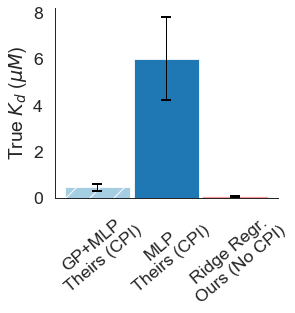

../results/figures/exploit/benchmark_lead_25.pdf


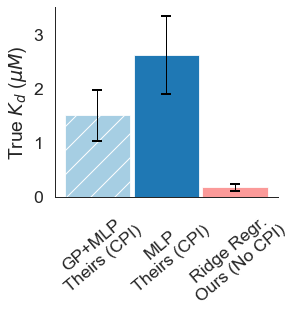

In [296]:

for n_lead in n_leads:
    df_subset = df[df.lead_num < n_lead]
    plt.figure(figsize=(panel_width, panel_height))
    bars = []
    for plot_position, method in zip(plot_positions, models):
        temp_df = df_subset[df_subset["model"] == method]
        
        
        color = color_map[method]
        vals = temp_df[val_name]
        bar_height = np.mean(vals)
        error_height = 1.96 * stats.sem(vals)
        label_name = method_name_map[method]

        uq = pd.unique(temp_df['uncertainty'])
        if len(uq) > 1: 
            raise ValueError()
        uq = uq[0]
        hatch = "/" if not uq == "No uncertainty" else None            
        
        bars.append(plt.bar(plot_position, bar_height, color=color, 
                            label = label_name, width=0.95, hatch=hatch))
        plt.errorbar(plot_position, bar_height, yerr= error_height, 
                     color="Black", capsize=5, capthick=2, linewidth=1)

    plt.xticks(ticks, labels=tick_labels, rotation=40)
    plt.ylabel(x_label_map[val_name])
#     plt.xlabel("Method")

    save_name= os.path.join(out_dir, f'benchmark_lead_{n_lead}.pdf')
    print(save_name)
    plt.savefig(save_name, bbox_inches="tight")
    plt.show()
    plt.close()


In [291]:
# n_leads = [ 5, 25 ]

# for n_lead in n_leads:
#     df_subset = df[df.lead_num < n_lead]
#     plt.figure(figsize=())
#     sns.barplot(x='model', y='Kd', data=df_subset, ci=95,
#                 order=models, hue='uncertainty', dodge=False,
#                 palette=sns.color_palette("RdBu", n_colors=len(models),),
#                 capsize=0.2,)
#     plt.ylim([ -100, 10100 ])
#     #plt.savefig('figures/benchmark_lead_{}.svg'.format(n_lead))
#     plt.savefig(os.path.join(out_dir, 'benchmark_lead_{}.png').format(n_lead))
#     plt.show()
#     plt.close()

#     gp_Kds = df_subset[df_subset.model == 'hybrid'].Kd
#     for model in models:
#         if model == 'hybrid':
#             continue
#         other_Kds = df_subset[df_subset.model == model].Kd
#         print('{} leads, t-test, GP vs {}:'.format(n_lead, model))
#         print('\tt = {:.4f}, P = {:.4g}'
#               .format(*stats.ttest_ind(gp_Kds, other_Kds,
#                                     equal_var=False)))
#     print('')
